# Project: Can we predict the outcome of cricket matches?


### Difficulty 1: Accurately predict the outcome of cricket matches
### Difficulty 2: Determine which variables are most important and logical

## STEP 1:  Full process of deriving the final data frame: match_number; history performance; only batting team.

1.  There was one game where team2's half-time data was not found in the innings_data, probably because team2 did not play, which is the same game as one game 'no result', which was identified by the news that rain interrupted the game on that day, which is a very special case, so I chose to skip this game directly and created a data frame with only records This was a very special case, so I chose to skip the match and create the initial data frame with only 123 matches, or 246 rows of data.


2.  In "The Hundred" cricket there are 20 overs per team and each over has 5 deliveries, so the first half of the game is a count of team1's score and wicket player out only!! Team1 is the team that bats. For these teams, it is the half-time stats that have discriminatory power.


3.  Wicket type: Bowled; Caught; Run out; Leg before wicket (LBW); Stumped; Hit wicket; Handled the ball; Obstructing the field; Hit the ball twice; Timed out. This will not be used as a statistical variable for the time being.

In [42]:
#general package
import pandas as pd
import numpy as np
import json
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.cm as cm # Define a color map

In [43]:
folder_path = os.getcwd() + '/hnd_json/'  
data_frame_list = []

home_venues = {
    "Southern Brave": "The Rose Bowl, Southampton",
    "Birmingham Phoenix": "Edgbaston, Birmingham",
    "Trent Rockets": "Trent Bridge, Nottingham",
    "Oval Invincibles": "Kennington Oval, London",
    "London Spirit": "Lord's, London",
    "Welsh Fire": "Sophia Gardens, Cardiff",
    "Manchester Originals": "Old Trafford, Manchester",
    "Northern Superchargers": "Headingley, Leeds"
}

def calculate_scores_and_wickets_per_match(data_dict):
    total_score = 0
    total_wickets_player_out = 0
    for innings in data_dict["innings"]:
        if innings["team"] == data_dict["info"]["teams"][0]:  
            for over in innings["overs"]:
                for delivery in over["deliveries"]:
                    total_score += delivery["runs"]["total"]
                    if "wickets" in delivery:
                        total_wickets_player_out += len(delivery["wickets"])  
            break  
    return total_score, total_wickets_player_out
#Only the first team's match data (bat) will be counted and the cycle will be exited immediately afterwards


for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        with open(os.path.join(folder_path, file_name), 'r') as f:
            data_dict = json.load(f)
            
            info_data = data_dict['info']

            team1 = info_data['teams'][0]
            team2 = info_data['teams'][1]
            
            gender = info_data['gender']
            season = info_data['season']
            
            date = info_data['dates'][0]
            
            match_number = info_data['event'].get('match_number', 'unknown')  
            
            venue = info_data['venue']
            city = info_data['city']
                    
            home_advantage_team1 = 'yes' if home_venues[team1] == venue else 'no'
            home_advantage_team2 = 'yes' if home_venues[team2] == venue else 'no'
            #home_advantage and toss_winner may be strong relationship          
            
            toss_winner = info_data['toss']['winner']
            toss_decision = info_data['toss']['decision']
            
            choose_to_bat_team1, choose_to_field_team1, forced_to_bat_team1, forced_to_field_team1 = 'no', 'no', 'no', 'no'
            choose_to_bat_team2, choose_to_field_team2, forced_to_bat_team2, forced_to_field_team2 = 'no', 'no', 'no', 'no'
 
            if toss_decision == 'bat':
                if toss_winner == team1:
                    choose_to_bat_team1 = 'yes'
                    forced_to_field_team2 = 'yes'
                else:
                    choose_to_bat_team2 = 'yes'
                    forced_to_field_team1 = 'yes'
            else:
                if toss_winner == team1:
                    choose_to_field_team1 = 'yes'
                    forced_to_bat_team2 = 'yes'
                else:
                    choose_to_field_team2 = 'yes'
                    forced_to_bat_team1 = 'yes'
                       
          
            # Set the reverse decision for the losing team based on the toss decision
            toss_decision_loser = 'field' if toss_decision == 'bat' else 'bat'
            toss_decision_team1 = toss_decision if toss_winner == team1 else toss_decision_loser
            toss_decision_team2 = toss_decision if toss_winner == team2 else toss_decision_loser
            
            winner = info_data['outcome'].get('winner', 'no winner')  

            result_team1 = 'win' if winner == team1 else ('loose' if winner == team2 else 'no result')
            result_team2 = 'win' if winner == team2 else ('loose' if winner == team1 else 'no result')
            if result_team1 == 'no result' or result_team2 == 'no result':
                continue
            
            total_score, total_wickets_player_out = calculate_scores_and_wickets_per_match(data_dict)
            

            data_frame_list.append([result_team1, team1, team2, gender, season, date, match_number, venue, city, home_advantage_team1, 
                        toss_winner, toss_decision_team1,
                        choose_to_bat_team1, choose_to_field_team1, forced_to_bat_team1, forced_to_field_team1,  
                        winner,total_score,total_wickets_player_out])


            data_frame_list.append([result_team2, team2, team1, gender, season, date, match_number, venue, city, home_advantage_team2, 
                        toss_winner, toss_decision_team2,
                        choose_to_bat_team2, choose_to_field_team2, forced_to_bat_team2, forced_to_field_team2, 
                        winner,total_score,total_wickets_player_out])

                            
df = pd.DataFrame(data_frame_list, columns=['Result', 
                                            'team', 'opponent', 'gender', 'season','date', 
                                            'match_number', 'venue', 'city', 'home_advantage',
                                            'toss_winner', 'toss_decision', 
                                            'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field',
                                            'winner','total_score','total_wickets_player_out'])

In [44]:
# convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

# sort by 'season' and 'date'
df = df.sort_values(by=['season', 'date'])

df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(columns=['date'])

column_order = ['Result','match_number', 'total_score','total_wickets_player_out', 
                'team', 'opponent',
                'gender', 'season', 
                'month','day', 
                'home_advantage','venue', 'city', 
                'toss_winner', 'winner',
                'toss_decision',
                'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field']
                                            

df = df[column_order]
df= df.reset_index(drop=True)

In [45]:
df #the initial data frame
#the double data frame

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
0,loose,1,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,yes,no,no,no
1,win,1,135,6,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,no,no,yes
2,win,1,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,no,no,yes,no
3,loose,1,145,8,Manchester Originals,Oval Invincibles,male,2021,7,22,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,yes,no,no
4,loose,2,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,bat,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,loose,unknown,134,6,Trent Rockets,Southern Brave,female,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,field,no,yes,no,no
242,loose,unknown,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,bat,yes,no,no,no
243,win,unknown,120,9,Trent Rockets,Manchester Originals,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,field,no,no,no,yes
244,loose,unknown,101,7,Southern Brave,Oval Invincibles,female,2022,9,3,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,yes,no,no,no


## STEP1.1: about 'match_number' (unknown: eliminator, assigned 40, final, assigned 50 )

8 matches without a match number all had a common date: 
2021-08-20, 
2021-08-21,
2022-09-02, 
2022-09-03.

Those without match numbers are eliminators and finals, while the maximum match number for women's cricket in 2022 is known to be 22 and the maximum match number for all three types of matches, 2022 men, 2021 men and 2021 women, is 32. To distinguish significantly between the eliminators and finals, assign a value of 40 to the eliminators and 50 to the finals.

In [46]:
matches_without_number = df[df.iloc[:,1]=='unknown'] #8 matches 
matches_without_number

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
118,loose,unknown,96,10,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,bat,no,no,yes,no
119,win,unknown,96,10,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,field,no,yes,no,no
120,win,unknown,114,7,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,bat,no,no,yes,no
121,loose,unknown,114,7,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,field,no,yes,no,no
122,win,unknown,168,5,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,bat,no,no,yes,no
123,loose,unknown,168,5,Birmingham Phoenix,Southern Brave,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,field,no,yes,no,no
124,win,unknown,121,6,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,no,no,yes,no
125,loose,unknown,121,6,Southern Brave,Oval Invincibles,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,field,no,yes,no,no
238,loose,unknown,150,7,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,bat,yes,no,no,no
239,win,unknown,150,7,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,field,no,no,no,yes


In [47]:
# Exclude rows where match_number is 'unknown'
matches_with_number = df[df['match_number'] != 'unknown']

# Convert the match_number column to integers
matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)

# Check the minimum, maximum and the distribution of match numbers
min_match_number = matches_with_number['match_number'].min()
max_match_number = matches_with_number['match_number'].max()
distribution = matches_with_number['match_number'].value_counts().sort_index()

print(f'Minimum match number: {min_match_number}\n')
print(f'Maximum match number: {max_match_number}\n')
print('Distribution of match numbers:')
print('--------------------------------')
for num, count in distribution.items():
    print(f'Match Number: {num} -> Count: {count}')

Minimum match number: 1

Maximum match number: 32

Distribution of match numbers:
--------------------------------
Match Number: 1 -> Count: 8
Match Number: 2 -> Count: 8
Match Number: 3 -> Count: 8
Match Number: 4 -> Count: 8
Match Number: 5 -> Count: 6
Match Number: 6 -> Count: 8
Match Number: 7 -> Count: 8
Match Number: 8 -> Count: 8
Match Number: 9 -> Count: 4
Match Number: 10 -> Count: 8
Match Number: 11 -> Count: 8
Match Number: 12 -> Count: 8
Match Number: 13 -> Count: 8
Match Number: 14 -> Count: 8
Match Number: 15 -> Count: 8
Match Number: 16 -> Count: 8
Match Number: 17 -> Count: 8
Match Number: 18 -> Count: 8
Match Number: 19 -> Count: 6
Match Number: 20 -> Count: 8
Match Number: 21 -> Count: 8
Match Number: 22 -> Count: 6
Match Number: 23 -> Count: 8
Match Number: 24 -> Count: 8
Match Number: 25 -> Count: 6
Match Number: 26 -> Count: 6
Match Number: 27 -> Count: 6
Match Number: 28 -> Count: 6
Match Number: 29 -> Count: 6
Match Number: 30 -> Count: 6
Match Number: 31 -> Coun

/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_50353/1754600911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)


### Observation obtained:


2021 men's team match_number is missing 5, 9 and 19;

2021 women's team match_number is missing 9 and 22;
   
2022 men's team match_number from 1-32 not missing;
   
2022 women's team match_number is missing 25-32;

The women's competition was curtailed due to the inclusion of women's cricket at the 2022 Commonwealth Games in Birmingham, reducing the number of players who were available for the start of the contest. As a result, the women's contest started a week later and each women's team only played six matches in the group stage, meaning some sides did not meet each other at that point in the competition.




In [48]:
### Assign values
df['season'] = df['season'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

def assign_match_number(row):
    if row['season'] == 2021 and row['month'] == 8 and row['day'] == 20:
        return 40  # semi-finals
    elif row['season'] == 2021 and row['month'] == 8 and row['day'] == 21:
        return 50  # finals
    elif row['season'] == 2022 and row['month'] == 9 and row['day'] == 2:
        return 40  # semi-finals
    elif row['season'] == 2022 and row['month'] == 9 and row['day'] == 3:
        return 50  # finals
    else:
        return row['match_number']  # keep the original match number

df['match_number'] = df.apply(assign_match_number, axis=1)

In [49]:
df[df['match_number']==40] 

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
118,loose,40,96,10,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,bat,no,no,yes,no
119,win,40,96,10,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,field,no,yes,no,no
120,win,40,114,7,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,bat,no,no,yes,no
121,loose,40,114,7,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,field,no,yes,no,no
238,loose,40,150,7,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,bat,yes,no,no,no
239,win,40,150,7,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,field,no,no,no,yes
240,win,40,134,6,Southern Brave,Trent Rockets,female,2022,9,2,yes,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,bat,no,no,yes,no
241,loose,40,134,6,Trent Rockets,Southern Brave,female,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,field,no,yes,no,no


In [50]:
df[df['match_number']==50] #finals in two seasons

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
122,win,50,168,5,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,bat,no,no,yes,no
123,loose,50,168,5,Birmingham Phoenix,Southern Brave,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,field,no,yes,no,no
124,win,50,121,6,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,no,no,yes,no
125,loose,50,121,6,Southern Brave,Oval Invincibles,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,field,no,yes,no,no
242,loose,50,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,bat,yes,no,no,no
243,win,50,120,9,Trent Rockets,Manchester Originals,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,field,no,no,no,yes
244,loose,50,101,7,Southern Brave,Oval Invincibles,female,2022,9,3,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,yes,no,no,no
245,win,50,101,7,Oval Invincibles,Southern Brave,female,2022,9,3,no,"Lord's, London",London,Southern Brave,Oval Invincibles,field,no,no,no,yes


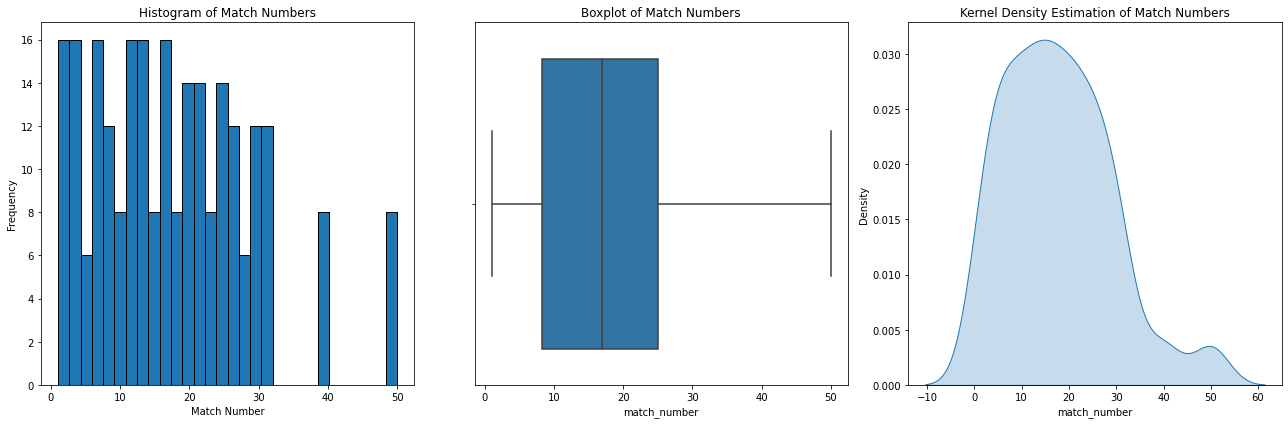

In [51]:
df_copy = df.copy()
df_copy['match_number'] = pd.to_numeric(df_copy['match_number'], errors='coerce')

match_numbers = df_copy['match_number'].dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

axs[0].hist(match_numbers, bins=30, edgecolor='black')
axs[0].set_title('Histogram of Match Numbers')
axs[0].set_xlabel('Match Number')
axs[0].set_ylabel('Frequency')

sns.boxplot(x=match_numbers, ax=axs[1])  
axs[1].set_title('Boxplot of Match Numbers')

sns.kdeplot(data=match_numbers, fill=True, ax=axs[2])
axs[2].set_title('Kernel Density Estimation of Match Numbers')

plt.tight_layout()  
#plt.savefig('/Users/quinne/Desktop/dissertation_picture/match_numbers.png') 
plt.show()

In [52]:
####Check the distribution after the assignment
def check_match_number_distribution(group):
    group_name = group.name
    matches_with_number = group[pd.to_numeric(group['match_number'], errors='coerce').notna()]   
    matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)

    min_match_number = matches_with_number['match_number'].min()
    max_match_number = matches_with_number['match_number'].max()
    distribution = matches_with_number['match_number'].value_counts().sort_index()

    print(f'For group {group_name}:')
    print(f'Minimum match number: {min_match_number}')
    print(f'Maximum match number: {max_match_number}')
    print('Distribution of match numbers:')
    print(distribution)
    print('--------------------')

df.groupby(['season', 'gender']).apply(check_match_number_distribution)

For group (2021, 'female'):
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
40    2
50    2
Name: match_number, dtype: int64
--------------------
For group (2021, 'male'):
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
6     2
7     2
8     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
20    2
21    2
22    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
40    2
50    2
Name: match_number, dtype: int64
--------------------
For group (2022, 'female'):
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9 

""


In [53]:
### Having already assigned the missing values in match_number
###the whole df_bat can be divided into four subsets according to season and male and female
###looking at them from smallest to largest match number
df_2021 = df.loc[df['season'] == 2021] 
df_2022 = df.loc[df['season'] == 2022] 

df_2021_men = df_2021.loc[df_2021['gender'] == 'male'] 
df_2021_women = df_2021.loc[df_2021['gender'] == 'female'] 
df_2022_men = df_2022.loc[df_2022['gender'] == 'male'] 
df_2022_women = df_2022.loc[df_2022['gender'] == 'female']

df_2021_men = df_2021_men.sort_values('match_number')
df_2021_women = df_2021_women.sort_values('match_number')
df_2022_men = df_2022_men.sort_values('match_number')
df_2022_women = df_2022_women.sort_values('match_number')

In [54]:
df_2021_men 
#2021 men's team match_number is missing 5, 9 and 19;
#31 matches, with the deletion of the one with no result
#19th Match (N), Manchester, August 05, 2021

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
2,win,1,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,no,no,yes,no
3,loose,1,145,8,Manchester Originals,Oval Invincibles,male,2021,7,22,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,yes,no,no
6,loose,2,144,6,London Spirit,Birmingham Phoenix,male,2021,7,23,no,"Edgbaston, Birmingham",Birmingham,Birmingham Phoenix,Birmingham Phoenix,bat,no,no,yes,no
7,win,2,144,6,Birmingham Phoenix,London Spirit,male,2021,7,23,yes,"Edgbaston, Birmingham",Birmingham,Birmingham Phoenix,Birmingham Phoenix,field,no,yes,no,no
8,loose,3,126,8,Southern Brave,Trent Rockets,male,2021,7,24,no,"Trent Bridge, Nottingham",Nottingham,Southern Brave,Trent Rockets,bat,yes,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,win,32,163,5,Welsh Fire,London Spirit,male,2021,8,18,yes,"Sophia Gardens, Cardiff",Cardiff,Welsh Fire,Welsh Fire,field,no,yes,no,no
118,loose,40,96,10,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,bat,no,no,yes,no
119,win,40,96,10,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",London,Southern Brave,Southern Brave,field,no,yes,no,no
122,win,50,168,5,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",London,Birmingham Phoenix,Southern Brave,bat,no,no,yes,no


In [55]:
df_2021_women #32 matches
#2021 women's team match_number is missing 9 and 22;

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
0,loose,1,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,bat,yes,no,no,no
1,win,1,135,6,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,field,no,no,no,yes
4,loose,2,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,bat,no,no,yes,no
5,win,2,128,6,London Spirit,Birmingham Phoenix,female,2021,7,23,no,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,field,no,yes,no,no
14,win,3,133,5,Southern Brave,Trent Rockets,female,2021,7,24,no,"Trent Bridge, Nottingham",Nottingham,Trent Rockets,Southern Brave,bat,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,win,32,95,9,London Spirit,Welsh Fire,female,2021,8,18,no,"Sophia Gardens, Cardiff",Cardiff,London Spirit,London Spirit,field,no,yes,no,no
120,win,40,114,7,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,bat,no,no,yes,no
121,loose,40,114,7,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",London,Birmingham Phoenix,Oval Invincibles,field,no,yes,no,no
124,win,50,121,6,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",London,Southern Brave,Oval Invincibles,bat,no,no,yes,no


In [56]:
df_2022_men #32 matches +2 matches (Elimination and final)
#2022 men's team match_number from 1-32 not missing

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
126,loose,1,107,7,Welsh Fire,Southern Brave,male,2022,8,3,no,"The Rose Bowl, Southampton",Southampton,Southern Brave,Southern Brave,bat,no,no,yes,no
127,win,1,107,7,Southern Brave,Welsh Fire,male,2022,8,3,yes,"The Rose Bowl, Southampton",Southampton,Southern Brave,Southern Brave,field,no,yes,no,no
128,win,2,171,6,London Spirit,Oval Invincibles,male,2022,8,4,no,"Kennington Oval, London",London,Oval Invincibles,London Spirit,bat,no,no,yes,no
129,loose,2,171,6,Oval Invincibles,London Spirit,male,2022,8,4,yes,"Kennington Oval, London",London,Oval Invincibles,London Spirit,field,no,yes,no,no
130,loose,3,161,4,Manchester Originals,Northern Superchargers,male,2022,8,5,yes,"Old Trafford, Manchester",Manchester,Northern Superchargers,Northern Superchargers,bat,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,win,32,143,9,Manchester Originals,Oval Invincibles,male,2022,8,31,yes,"Old Trafford, Manchester",Manchester,Oval Invincibles,Manchester Originals,field,no,no,no,yes
238,loose,40,150,7,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,bat,yes,no,no,no
239,win,40,150,7,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,field,no,no,no,yes
242,loose,50,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",London,Manchester Originals,Trent Rockets,bat,yes,no,no,no


In [57]:
df_2022_women 
#2022 women's team match_number is missing 25-32;
#24 matches +2 matches (Elimination and final)

#The following sides did not play each other in the group stage, 
#due to the shortened women's competition: 
#Oval Invincibles and Welsh Fire, 
#Northern Superchargers and Trent Rockets, 
#London Spirit and Manchester Originals, 
#Southern Brave and Birmingham Phoenix.

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,home_advantage,venue,city,toss_winner,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
142,loose,1,143,5,Northern Superchargers,Oval Invincibles,female,2022,8,11,no,"Kennington Oval, London",London,Oval Invincibles,Oval Invincibles,bat,no,no,yes,no
143,win,1,143,5,Oval Invincibles,Northern Superchargers,female,2022,8,11,yes,"Kennington Oval, London",London,Oval Invincibles,Oval Invincibles,field,no,yes,no,no
146,loose,2,155,4,London Spirit,Southern Brave,female,2022,8,12,no,"The Rose Bowl, Southampton",Southampton,London Spirit,Southern Brave,bat,yes,no,no,no
147,win,2,155,4,Southern Brave,London Spirit,female,2022,8,12,yes,"The Rose Bowl, Southampton",Southampton,London Spirit,Southern Brave,field,no,no,no,yes
152,win,3,119,5,Trent Rockets,Manchester Originals,female,2022,8,13,no,"Old Trafford, Manchester",Manchester,Manchester Originals,Trent Rockets,bat,no,no,yes,no
153,loose,3,119,5,Manchester Originals,Trent Rockets,female,2022,8,13,yes,"Old Trafford, Manchester",Manchester,Manchester Originals,Trent Rockets,field,no,yes,no,no
154,win,4,161,5,Birmingham Phoenix,Welsh Fire,female,2022,8,13,no,"Sophia Gardens, Cardiff",Cardiff,Welsh Fire,Birmingham Phoenix,bat,no,no,yes,no
155,loose,4,161,5,Welsh Fire,Birmingham Phoenix,female,2022,8,13,yes,"Sophia Gardens, Cardiff",Cardiff,Welsh Fire,Birmingham Phoenix,field,no,yes,no,no
164,win,5,127,4,Northern Superchargers,London Spirit,female,2022,8,14,yes,"Headingley, Leeds",Leeds,London Spirit,Northern Superchargers,bat,no,no,yes,no
165,loose,5,127,4,London Spirit,Northern Superchargers,female,2022,8,14,no,"Headingley, Leeds",Leeds,London Spirit,Northern Superchargers,field,no,yes,no,no


### Conclusion about 2 seasons of men's and women's matches

According to the official information:

1.    Both men's and women's cricket 2021 will have 32 matches each in the group stage, plus their respective semi-finals and finals, which should give a total of 64+4=68 matches.
2.    However, due to incomplete data, the 2021 men's matches with match_numbers = 5,9,19('no result',deleted) and the 2021 women's matches with match_number = 9,22 are missing, making a total of 4 matches missing and 1 deleted, so the figure for 2021 is only 64 matches.
3.    For the 2022 men's group matches there are 32 matches, plus the semi-finals and finals, making a total of 34 matches;
4.    For the 2022 women's group matches there are 24 matches, plus the semi-finals and finals, making a total of 26 matches.

<table>
<tr>
    <th><font color="blue" size="4">Season</font></th>
    <th><font color="red" size="4">2021</font></th>
    <th><font color="red" size="4">2022</font></th>
    <th><font color="green" size="4">Total matches</font></th>
</tr>
<tr>
    <td><font size="4">Men</font></td>
    <td><font size="4">29+2=31</font></td>
    <td><font size="4">32+2=34</font></td>
    <td><font size="4">65</font></td>
</tr>
<tr>
    <td><font size="4">Women</font></td>
    <td><font size="4">30+2=32</font></td>
    <td><font size="4">24+2=26</font></td>
    <td><font size="4">58</font></td>
</tr>
<tr>
    <td><b><font size="4">Total matches</font></b></td>
    <td><b><font size="4">63</font></b></td>
    <td><b><font size="4">60</font></b></td>
    <td><b><font size="4">123</font></b></td>
</tr>
</table>


## STEP1.2: four new variables about the team's historical performance

Note that: Sometimes teams appear in the 'opponent' rather than the 'team' column, so we need to consider historical performance in a large 'df' context rather than just in 'df_bat'.


| Variable Name | Description |
|---------------|-------------|
| Average Win Percentage | The average percentage of matches that a team has won in its history. Note that the statistics for men's and women's teams are differentiated even if the team names are the same. |
| Average Half-Court Score | The average score a team achieves in the half-court during its history. Again, statistics are differentiated for men's and women's teams. |
| Average Number of Wickets Player Outs | The average number of times a player from the team has been out due to wickets. Differentiated statistics are provided for men's and women's teams. |
| Last Match Result | The result of the team's last match. This variable also differentiates between the statistics for men's and women's teams. |


In [58]:
#Reorder by team name, gender, season and match number
df = df.sort_values(['team', 'gender','season', 'match_number'])

df['Result_num'] = df['Result'].map({'win': 1, 'loose': 0})

df['avg_win_rate'] = df.groupby(['team', 'gender'])['Result_num'].apply(lambda x: x.shift().expanding().mean())
df['avg_score'] = df.groupby(['team', 'gender'])['total_score'].apply(lambda x: x.shift().expanding().mean())
df['avg_wickets_out'] = df.groupby(['team', 'gender'])['total_wickets_player_out'].apply(lambda x: x.shift().expanding().mean())

df['last_match_result'] = df.groupby(['team', 'gender'])['Result'].shift()

In [59]:
df.drop(['Result_num'], axis=1, inplace=True)

In [60]:
df

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,...,winner,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,avg_win_rate,avg_score,avg_wickets_out,last_match_result
4,loose,2,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,...,London Spirit,bat,no,no,yes,no,NaN,NaN,NaN,NaN
18,win,6,113,9,Birmingham Phoenix,Manchester Originals,female,2021,7,25,...,Birmingham Phoenix,bat,yes,no,no,no,0.000000,128.000000,6.000000,loose
34,loose,11,140,4,Birmingham Phoenix,Southern Brave,female,2021,7,30,...,Southern Brave,bat,no,no,yes,no,0.500000,120.500000,7.500000,win
53,loose,14,145,5,Birmingham Phoenix,Trent Rockets,female,2021,8,1,...,Trent Rockets,field,no,no,no,yes,0.333333,127.000000,6.333333,loose
62,loose,18,129,9,Birmingham Phoenix,Oval Invincibles,female,2021,8,4,...,Oval Invincibles,bat,yes,no,no,no,0.250000,131.500000,6.000000,loose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,loose,16,149,9,Welsh Fire,Manchester Originals,male,2022,8,16,...,Manchester Originals,field,no,yes,no,no,0.272727,148.545455,5.727273,loose
194,loose,22,129,8,Welsh Fire,Southern Brave,male,2022,8,22,...,Southern Brave,bat,no,no,yes,no,0.250000,148.583333,6.000000,loose
205,loose,24,156,6,Welsh Fire,London Spirit,male,2022,8,24,...,London Spirit,field,no,yes,no,no,0.230769,147.076923,6.153846,loose
212,loose,26,114,4,Welsh Fire,Northern Superchargers,male,2022,8,26,...,Northern Superchargers,bat,yes,no,no,no,0.214286,147.714286,6.142857,loose


In [61]:
#save the full data frame (double)
df.reset_index(drop=True).to_csv('/Users/quinne/Desktop/full_dataframe.csv', index=False)

## STEP1.3: for batting team, 'total_score' is actually halftime score/ runs


In "The Hundred" cricket there are 20 overs per team and 5 deliveries per over, so only Team1's score and wicket player out are counted for the first half of the game!!! These two variables are only valid for teams with a toss decision of bat, as team1 always acts first (either bat or field).

According to traditional cricket rules, if one team chooses to bat first, then they will bat in the first half of the game and keep the field in the second half, the other team is (forced to field). 

Conversely, if one team chooses to field first, then they will field in the first half of the game and bat in the second half, while the other team is forced to bat. 

Therefore, the team batting in the first half is: toss decision for the team batting.

In [62]:
df_bat_new = df[df['toss_decision'] == 'bat']
df_bat_new = df_bat_new.sort_values(['season', 'month', 'day', 'match_number'])

In [63]:
#toss decision only 'bat', choose to field & forced to field only 'no'
df_bat_new.drop(['choose_to_field','forced_to_field','toss_decision'], axis=1, inplace=True)

In [64]:
df_bat_new

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,...,venue,city,toss_winner,winner,choose_to_bat,forced_to_bat,avg_win_rate,avg_score,avg_wickets_out,last_match_result
0,loose,1,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,...,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,yes,no,NaN,NaN,NaN,NaN
2,win,1,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,...,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,no,yes,NaN,NaN,NaN,NaN
4,loose,2,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,...,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,no,yes,NaN,NaN,NaN,NaN
6,loose,2,144,6,London Spirit,Birmingham Phoenix,male,2021,7,23,...,"Edgbaston, Birmingham",Birmingham,Birmingham Phoenix,Birmingham Phoenix,no,yes,NaN,NaN,NaN,NaN
14,win,3,133,5,Southern Brave,Trent Rockets,female,2021,7,24,...,"Trent Bridge, Nottingham",Nottingham,Trent Rockets,Southern Brave,no,yes,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,loose,32,143,9,Oval Invincibles,Manchester Originals,male,2022,8,31,...,"Old Trafford, Manchester",Manchester,Oval Invincibles,Manchester Originals,yes,no,0.571429,147.285714,6.071429,win
238,loose,40,150,7,London Spirit,Manchester Originals,male,2022,9,2,...,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,yes,no,0.400000,145.200000,5.933333,loose
240,win,40,134,6,Southern Brave,Trent Rockets,female,2022,9,2,...,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,no,yes,0.800000,125.066667,5.800000,loose
242,loose,50,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,...,"Lord's, London",London,Manchester Originals,Trent Rockets,yes,no,0.533333,157.400000,6.333333,win


In [65]:
#save the final data frame
df_bat_new.reset_index(drop=True).to_csv('/Users/quinne/Desktop/final_dataframe.csv', index=False)

## STEP2: EDA (Target: Result)

In [104]:
#statistical package
from scipy.stats.stats import pearsonr
from scipy.stats import chi2_contingency

#dashboard
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

In [66]:
###read files##
##df = pd.read_csv('/Users/quinne/Desktop/full_dataframe.csv')
df_bat = pd.read_csv('/Users/quinne/Desktop/final_dataframe.csv')

In [67]:
df_bat

,Result,match_number,total_score,total_wickets_player_out,team,opponent,gender,season,month,day,...,venue,city,toss_winner,winner,choose_to_bat,forced_to_bat,avg_win_rate,avg_score,avg_wickets_out,last_match_result
0,loose,1,135,6,Manchester Originals,Oval Invincibles,female,2021,7,21,...,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,yes,no,NaN,NaN,NaN,NaN
1,win,1,145,8,Oval Invincibles,Manchester Originals,male,2021,7,22,...,"Kennington Oval, London",London,Manchester Originals,Oval Invincibles,no,yes,NaN,NaN,NaN,NaN
2,loose,2,128,6,Birmingham Phoenix,London Spirit,female,2021,7,23,...,"Edgbaston, Birmingham",Birmingham,London Spirit,London Spirit,no,yes,NaN,NaN,NaN,NaN
3,loose,2,144,6,London Spirit,Birmingham Phoenix,male,2021,7,23,...,"Edgbaston, Birmingham",Birmingham,Birmingham Phoenix,Birmingham Phoenix,no,yes,NaN,NaN,NaN,NaN
4,win,3,133,5,Southern Brave,Trent Rockets,female,2021,7,24,...,"Trent Bridge, Nottingham",Nottingham,Trent Rockets,Southern Brave,no,yes,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,loose,32,143,9,Oval Invincibles,Manchester Originals,male,2022,8,31,...,"Old Trafford, Manchester",Manchester,Oval Invincibles,Manchester Originals,yes,no,0.571429,147.285714,6.071429,win
119,loose,40,150,7,London Spirit,Manchester Originals,male,2022,9,2,...,"The Rose Bowl, Southampton",Southampton,London Spirit,Manchester Originals,yes,no,0.400000,145.200000,5.933333,loose
120,win,40,134,6,Southern Brave,Trent Rockets,female,2022,9,2,...,"The Rose Bowl, Southampton",Southampton,Trent Rockets,Southern Brave,no,yes,0.800000,125.066667,5.800000,loose
121,loose,50,120,9,Manchester Originals,Trent Rockets,male,2022,9,3,...,"Lord's, London",London,Manchester Originals,Trent Rockets,yes,no,0.533333,157.400000,6.333333,win


In [68]:
df_bat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Result                    123 non-null    object 
 1   match_number              123 non-null    int64  
 2   total_score               123 non-null    int64  
 3   total_wickets_player_out  123 non-null    int64  
 4   team                      123 non-null    object 
 5   opponent                  123 non-null    object 
 6   gender                    123 non-null    object 
 7   season                    123 non-null    int64  
 8   month                     123 non-null    int64  
 9   day                       123 non-null    int64  
 10  home_advantage            123 non-null    object 
 11  venue                     123 non-null    object 
 12  city                      123 non-null    object 
 13  toss_winner               123 non-null    object 
 14  winner    

In [69]:
df_bat.describe()

,match_number,total_score,total_wickets_player_out,season,month,day,avg_win_rate,avg_score,avg_wickets_out
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,115.000000,115.000000,115.000000
mean,17.723577,137.121951,6.219512,2021.487805,7.845528,16.918699,0.502902,137.678981,6.208945
std,11.434275,25.037541,1.981623,0.501896,0.444133,9.064065,0.250685,13.103968,0.841827
min,1.000000,76.000000,2.000000,2021.000000,7.000000,1.000000,0.000000,112.500000,4.000000
25%,8.500000,122.000000,5.000000,2021.000000,8.000000,10.000000,0.348485,127.181818,5.720779
50%,17.000000,137.000000,6.000000,2021.000000,8.000000,17.000000,0.500000,139.166667,6.125000
75%,25.000000,153.000000,8.000000,2022.000000,8.000000,24.500000,0.654762,147.397436,6.801282
max,50.000000,208.000000,10.000000,2022.000000,9.000000,31.000000,1.000000,173.000000,9.000000


In [70]:
#checking the missing value
df_bat.isnull().sum()

Result                      0
match_number                0
total_score                 0
total_wickets_player_out    0
team                        0
opponent                    0
gender                      0
season                      0
month                       0
day                         0
home_advantage              0
venue                       0
city                        0
toss_winner                 0
winner                      0
choose_to_bat               0
forced_to_bat               0
avg_win_rate                8
avg_score                   8
avg_wickets_out             8
last_match_result           8
dtype: int64

In [71]:
df_bat = df_bat.fillna(0)

Because there is no historical data for each team's first match in 2021, there are missing values, which are replaced by 0.

In [72]:
columns_to_check = [
    'Result',
    'match_number', 
    'total_score',
    'total_wickets_player_out', 
    'team', 
    'opponent', 
    'gender', 
    'season', 
    'month',
    'day',
    'home_advantage',
    'venue', 
    'city', 
    'toss_winner', 
    'winner', 
    'choose_to_bat',
    'forced_to_bat',
    'avg_win_rate',
    'avg_score',
    'avg_wickets_out',
    'last_match_result'
]


# 8 teams, 8 venues (because London has two venues)
for col in columns_to_check:
    print(f"\n--- Distribution for column: {col} ---")
    print(df_bat[col].value_counts())
    print("\n")


--- Distribution for column: Result ---
loose    68
win      55
Name: Result, dtype: int64



--- Distribution for column: match_number ---
1     4
14    4
24    4
23    4
40    4
21    4
20    4
2     4
18    4
17    4
16    4
15    4
13    4
12    4
11    4
10    4
8     4
7     4
6     4
50    4
4     4
3     4
29    3
32    3
31    3
30    3
19    3
28    3
27    3
26    3
25    3
22    3
5     3
9     2
Name: match_number, dtype: int64



--- Distribution for column: total_score ---
122    5
143    5
145    5
127    4
123    3
      ..
95     1
96     1
168    1
107    1
101    1
Name: total_score, Length: 74, dtype: int64



--- Distribution for column: total_wickets_player_out ---
6     30
5     17
7     17
8     15
4     15
9     10
3      9
10     8
2      2
Name: total_wickets_player_out, dtype: int64



--- Distribution for column: team ---
Welsh Fire                18
Northern Superchargers    18
Birmingham Phoenix        17
London Spirit             16
Trent Rockets      

We can simply observe the following pattern through the values of each variable:
1. the city that hosts the most matches is London and the venue is Lord's;
2. the number of players most often out at half-time is 6;
3. the strongest team would be Southern Brave, as it has the most toss winners, the most winners, and the most appearances in opponents; The weakest team would be Welsh Fire, as it has the least number of winners.
4. the occurrence of home advantage is only about 38%;
5. only 34 games were actively batted, while 89 games were forced to be batted, the vast majority.

## STEP2.1: Target variable--Result

In [73]:
df_bat['Result'].unique()

array(['loose', 'win'], dtype=object)

In [74]:
print(df_bat['Result'].value_counts())
#relatively balanced: target variable dataset

loose    68
win      55
Name: Result, dtype: int64


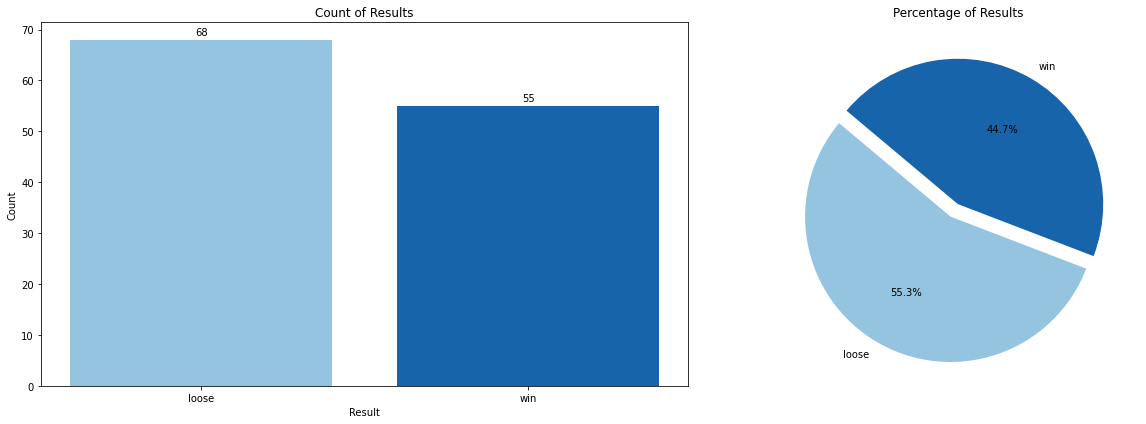

In [75]:
colors = cm.Blues(np.linspace(0.4, 0.8, 2))
result_counts = df_bat['Result'].value_counts()
result_percentage = result_counts / len(df_bat) * 100

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(result_counts.index, result_counts.values, color=colors)
plt.xlabel('Result')
plt.ylabel('Count')
plt.title('Count of Results')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(result_percentage, labels=result_percentage.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.1, 0))
plt.title('Percentage of Results')

plt.tight_layout()
#plt.savefig('/Users/quinne/Desktop/dissertation_picture/results.png') 
plt.show()

## STEP2.2: For binary variables 

#### Group1:  'gender' 'season' 'home_advantage' 'choose_to_bat''forced_to_bat' ‘last_match_result’

### STEP2.2.1: Visualisation for binary variables 

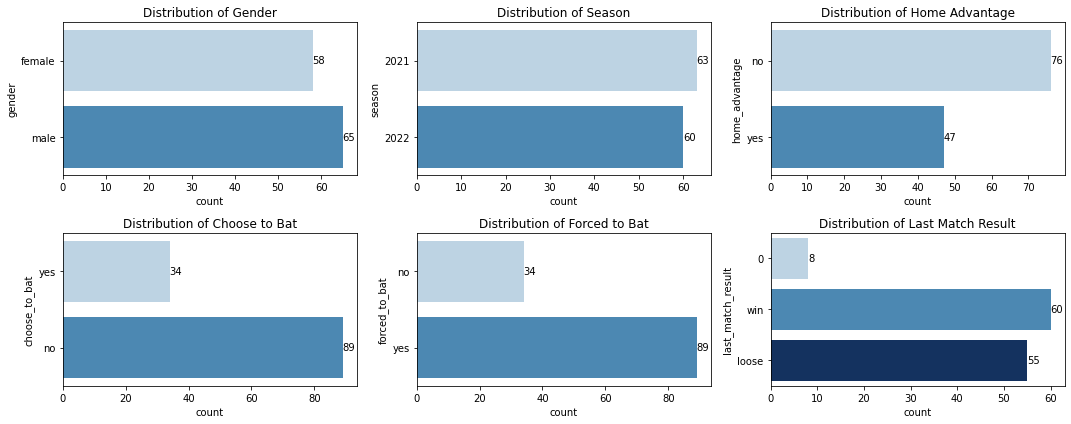

In [76]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
colors = cm.Blues(np.linspace(0.3, 1, 3))

columns = ['gender', 'season', 'home_advantage', 'choose_to_bat', 'forced_to_bat', 'last_match_result']
titles = ['Distribution of Gender', 'Distribution of Season', 'Distribution of Home Advantage',
          'Distribution of Choose to Bat', 'Distribution of Forced to Bat', 'Distribution of Last Match Result']

for i, col in enumerate(columns):
    sns.countplot(y=col, data=df_bat,palette=colors, ax=ax[i//3, i%3]) 
    ax[i//3, i%3].set_title(titles[i])
    for p in ax[i//3, i%3].patches:
        width = p.get_width()
        ax[i//3, i%3].text(width, p.get_y()+p.get_height()/2,
                           '{:.0f}'.format(width), 
                           ha='left', va='center')

plt.tight_layout()
#plt.savefig('/Users/quinne/Desktop/dissertation_picture/group1_hist.png') 
plt.show()

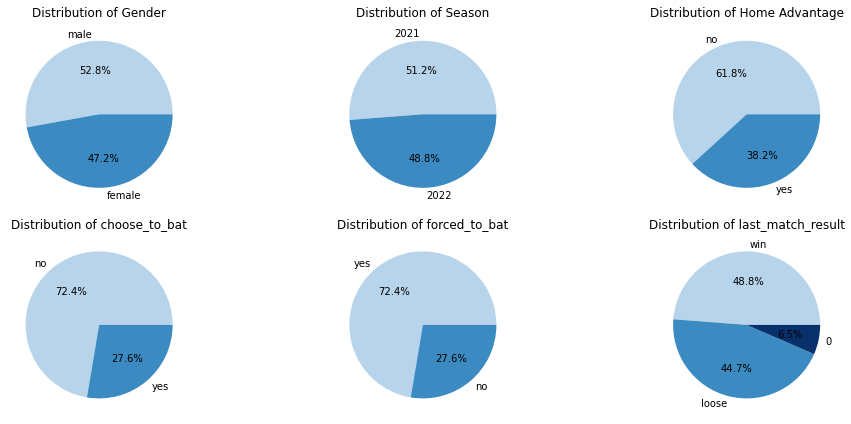

In [77]:
colors = cm.Blues(np.linspace(0.3, 1, 3))
fig, ax = plt.subplots(2, 3, figsize=(15, 6))  

gender_counts = df_bat['gender'].value_counts()
ax[0, 0].pie(gender_counts, labels = gender_counts.index, autopct='%1.1f%%', colors=colors)
ax[0, 0].set_title('Distribution of Gender')

season_counts = df_bat['season'].value_counts()
ax[0, 1].pie(season_counts, labels = season_counts.index, autopct='%1.1f%%', colors=colors)
ax[0, 1].set_title('Distribution of Season')

home_advantage_counts = df_bat['home_advantage'].value_counts()
ax[0, 2].pie(home_advantage_counts, labels = home_advantage_counts.index, autopct='%1.1f%%', colors=colors)
ax[0, 2].set_title('Distribution of Home Advantage')

choose_to_bat_counts = df_bat['choose_to_bat'].value_counts()
ax[1, 0].pie(choose_to_bat_counts, labels = choose_to_bat_counts.index, autopct='%1.1f%%', colors=colors)
ax[1, 0].set_title('Distribution of choose_to_bat')

forced_to_bat_counts = df_bat['forced_to_bat'].value_counts()
ax[1, 1].pie(forced_to_bat_counts, labels = forced_to_bat_counts.index, autopct='%1.1f%%', colors=colors)
ax[1, 1].set_title('Distribution of forced_to_bat')

last_match_result_counts = df_bat['last_match_result'].value_counts()
ax[1, 2].pie(last_match_result_counts, labels = last_match_result_counts.index, autopct='%1.1f%%', colors=colors)
ax[1, 2].set_title('Distribution of last_match_result')

plt.tight_layout()
#plt.savefig('/Users/quinne/Desktop/dissertation_picture/group1_bar.png') 
plt.show()

In [92]:
df_bat['choose_to_bat'] = df_bat['choose_to_bat'].astype(str)
df_bat['forced_to_bat'] = df_bat['forced_to_bat'].astype(str)

cross_table = pd.crosstab(df_bat['choose_to_bat'], df_bat['forced_to_bat'], margins=True)

print(cross_table)

forced_to_bat  no  yes  All
choose_to_bat              
no              0   89   89
yes            34    0   34
All            34   89  123


In [93]:
contingency_table = [[0, 89], [34, 0]]
correlation, _ = pearsonr(contingency_table[0], contingency_table[1])

correlation

-1.0

### Action:

Observe that:'choose_to_bat' and 'forced_to_bat' are completely opposite variables with a correlation coefficient of -1. Therefore, to avoid multicollinearity, delete 'forced_to_bat' and keep only 'choose_to_bat'

In [94]:
df_bat = df_bat.drop('forced_to_bat', axis=1)

### STEP2.2.2: considering the variables of group1 and the target variable (result) together

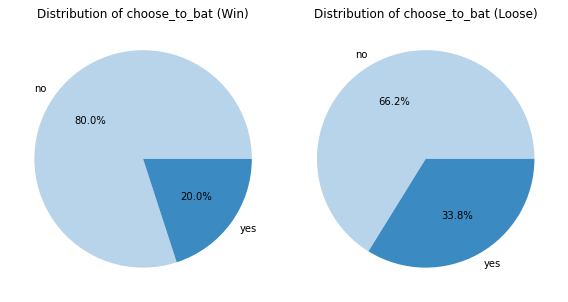

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

win_counts = df_bat[df_bat['Result'] == 'win']['choose_to_bat'].value_counts()
ax[0].pie(win_counts, labels = win_counts.index, autopct='%1.1f%%', colors=colors)
ax[0].set_title('Distribution of choose_to_bat (Win)')

lose_counts = df_bat[df_bat['Result'] == 'loose']['choose_to_bat'].value_counts()
ax[1].pie(lose_counts, labels = lose_counts.index, autopct='%1.1f%%', colors=colors)
ax[1].set_title('Distribution of choose_to_bat (Loose)')

plt.tight_layout()
plt.show()

In the case of winning the match, the choice to bat first was not made most of the time (80%); whereas in the case of losing the match, the choice to bat first was made in approximately 34% of cases. This could imply that there may be some correlation between the choice to bat first or not in this dataset and the outcome of the game.

In [118]:
binary_variables = ['gender', 'season', 'home_advantage', 'choose_to_bat',  'last_match_result']

for variable in binary_variables:
    contingency_table = pd.crosstab(df_bat['Result'], df_bat[variable])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nFor variable: {variable}")
    print("chi2 statistic:", chi2)
    print("p value:", p)
        
#We do not have sufficient evidence that these variables 
#are significantly associated with winning outcomes.


For variable: gender
chi2 statistic: 0.0421368210896608
p value: 0.837359186831013

For variable: season
chi2 statistic: 0.9388851222307113
p value: 0.33256472470192694

For variable: home_advantage
chi2 statistic: 0.8592993596960319
p value: 0.3539348350651833

For variable: choose_to_bat
chi2 statistic: 2.254973010203901
p value: 0.1331857776693032

For variable: last_match_result
chi2 statistic: 0.2867956976178903
p value: 0.8664093004089439


### STEP2.2.3: bivariate analysis within group1

In [166]:
group1_variables = ['gender', 'season', 'home_advantage', 'choose_to_bat', 'last_match_result']

for i in range(len(group1_variables)):
    for j in range(i+1, len(group1_variables)):
        var1 = group1_variables[i]
        var2 = group1_variables[j]
        
        cross_table = pd.crosstab(df_bat[var1], df_bat[var2])        
        chi2, p, dof, expected = chi2_contingency(cross_table)
        
        print(f"Chi2 statistic for {var1} and {var2}: ", chi2)
        print(f"P value for {var1} and {var2}: ", p)
        print("-------------------")

Chi2 statistic for gender and season:  0.4196518567639255
P value for gender and season:  0.5171108120912608
-------------------
Chi2 statistic for gender and home_advantage:  0.24716337428451718
P value for gender and home_advantage:  0.6190795531943524
-------------------
Chi2 statistic for gender and choose_to_bat:  0.04625699727034119
P value for gender and choose_to_bat:  0.8297093131770328
-------------------
Chi2 statistic for gender and last_match_result:  0.032032794791415485
P value for gender and last_match_result:  0.984111183062494
-------------------
Chi2 statistic for season and home_advantage:  0.3410859262517995
P value for season and home_advantage:  0.5592030744148571
-------------------
Chi2 statistic for season and choose_to_bat:  0.0011855584930601597
P value for season and choose_to_bat:  0.9725327141180052
-------------------
Chi2 statistic for season and last_match_result:  10.733214285714286
P value for season and last_match_result:  0.004669948931233592
-----

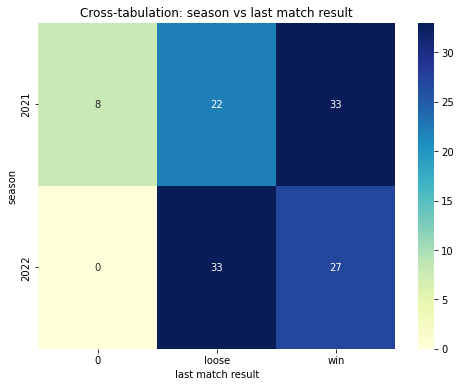

In [170]:
#P value for season and last_match_result:  0.004669948931233592
cross_tab = pd.crosstab(df_bat['season'], df_bat['last_match_result'])
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Cross-tabulation: season vs last match result')
plt.xlabel('last match result')
plt.ylabel('season')
plt.show()

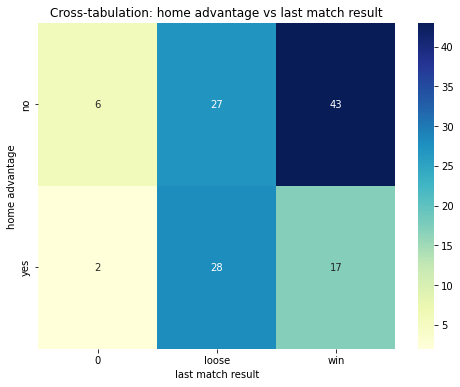

In [169]:
#P value for home_advantage and last_match_result:  0.032926568648917534
cross_tab = pd.crosstab(df_bat['home_advantage'], df_bat['last_match_result'])
plt.figure(figsize=(8, 6))
sns.heatmap(cross_tab, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Cross-tabulation: home advantage vs last match result')
plt.xlabel('last match result')
plt.ylabel('home advantage')
plt.show()

#This could mean that there are more cases where a team has an advantage at home after a defeat in the previous game, 
#and more cases where a team does not have home advantage after a win in the previous game

This could mean that there are more cases where a team has an advantage at home after a defeat in the previous game, and more cases where a team does not have home advantage after a win in the previous game.

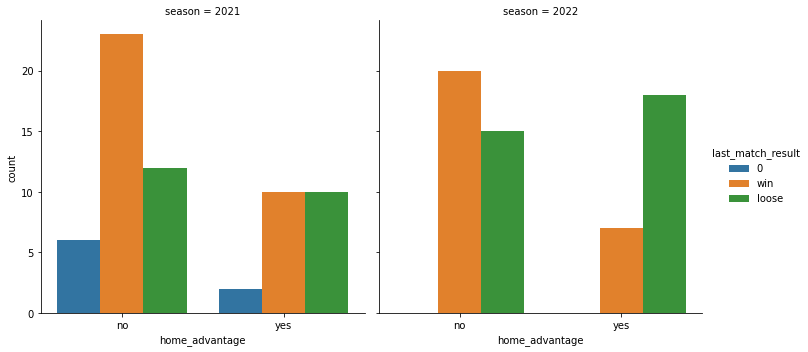

In [147]:
sns.catplot(x='home_advantage', hue="last_match_result", col="season", data=df_bat, kind='count')

### Dashboard for group1

In [156]:
app = dash.Dash(__name__)

fig_gender = px.pie(df_bat, names='gender', title='Distribution of Gender')
fig_season = px.pie(df_bat, names='season', title='Distribution of Season')
fig_home_advantage = px.pie(df_bat, names='home_advantage', title='Distribution of Home Advantage')
fig_choose_to_bat = px.pie(df_bat, names='choose_to_bat', title='Distribution of Choose to Bat')
fig_last_match_result = px.pie(df_bat, names='last_match_result', title='Distribution of Last Match Result')

app.layout = html.Div([
    dcc.Graph(figure=fig_gender, id='gender-graph'),
    dcc.Graph(figure=fig_season, id='season-graph'),
    dcc.Graph(figure=fig_home_advantage, id='home-advantage-graph'),
    dcc.Graph(figure=fig_choose_to_bat, id='choose-to-bat-graph'),
    dcc.Graph(figure=fig_last_match_result, id='last-match-result-graph')
])

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

## STEP2.3:  For Multicategorical Variables

#### Group2:  6 variables:  'winner'  'team' 'opponent' 'toss_winner' 'venue' 'city' 

In [144]:
cols_to_check = ['winner', 'toss_winner', 'team', 'opponent', 'city', 'venue']
for col in cols_to_check:
    unique_values = df_bat[col].unique()
    print(f"Unique values in column '{col}': {unique_values}")

Unique values in column 'winner': ['Oval Invincibles' 'London Spirit' 'Birmingham Phoenix' 'Southern Brave'
 'Trent Rockets' 'Northern Superchargers' 'Welsh Fire'
 'Manchester Originals']
Unique values in column 'toss_winner': ['Manchester Originals' 'London Spirit' 'Birmingham Phoenix'
 'Trent Rockets' 'Southern Brave' 'Northern Superchargers' 'Welsh Fire'
 'Oval Invincibles']
Unique values in column 'team': ['Manchester Originals' 'Oval Invincibles' 'Birmingham Phoenix'
 'London Spirit' 'Southern Brave' 'Welsh Fire' 'Northern Superchargers'
 'Trent Rockets']
Unique values in column 'opponent': ['Oval Invincibles' 'Manchester Originals' 'London Spirit'
 'Birmingham Phoenix' 'Trent Rockets' 'Northern Superchargers'
 'Southern Brave' 'Welsh Fire']
Unique values in column 'city': ['London' 'Birmingham' 'Nottingham' 'Leeds' 'Manchester' 'Cardiff'
 'Southampton']
Unique values in column 'venue': ['Kennington Oval, London' 'Edgbaston, Birmingham'
 'Trent Bridge, Nottingham' 'Headingley, Lee

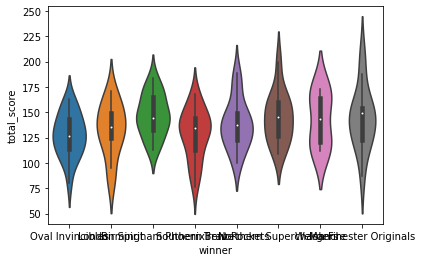

In [176]:
sns.violinplot(x='winner', y='total_score', data=df_bat)
plt.show()

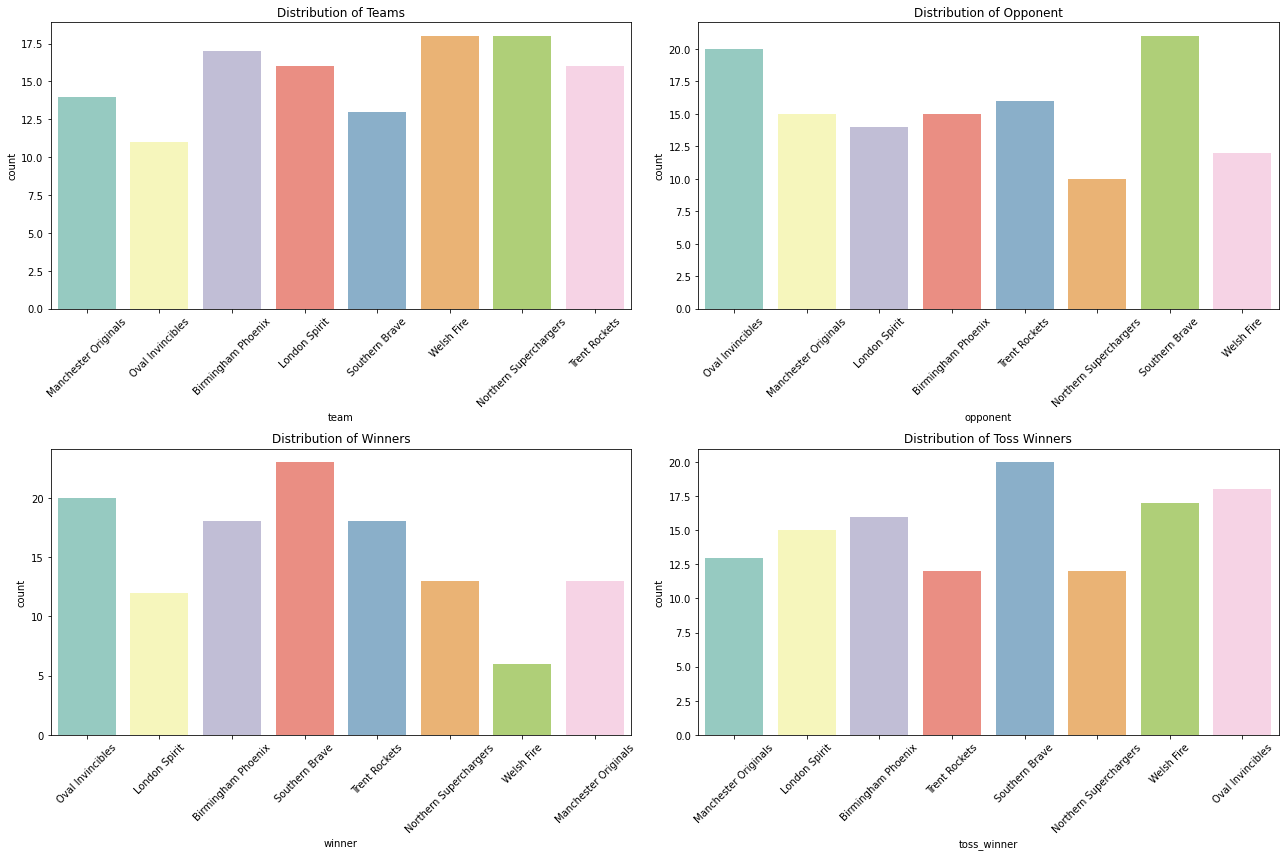

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

# 定义调色板
palette = sns.color_palette("Set3", 8)

# 获取数据中唯一的队伍列表，并与调色板顺序匹配
teams = df_bat['team'].unique()
team_palette = [palette[i % len(palette)] for i in range(len(teams))]
team_colors = dict(zip(teams, team_palette))

fig, ax = plt.subplots(2, 2, figsize=(18, 12))  

sns.countplot(x='team', data=df_bat, ax=ax[0,0], palette=team_colors.values())
ax[0,0].set_title('Distribution of Teams')
ax[0,0].tick_params(axis='x', rotation=45)

sns.countplot(x='opponent', data=df_bat, ax=ax[0,1], palette=team_colors.values())
ax[0,1].set_title('Distribution of Opponent')
ax[0,1].tick_params(axis='x', rotation=45)

sns.countplot(x='winner', data=df_bat, ax=ax[1,0], palette=team_colors.values())
ax[1,0].set_title('Distribution of Winners')
ax[1,0].tick_params(axis='x', rotation=45) 

sns.countplot(x='toss_winner', data=df_bat, ax=ax[1, 1], palette=team_colors.values())
ax[1,1].set_title('Distribution of Toss Winners')
ax[1,1].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

In [146]:
### Overall winning percentage for each team: Southern Brave is highest, Welsh Fire is lowest
teams = df_bat['team'].unique()  
win_rates = {}  
for team in teams:
    team_wins = df_bat['winner'][df_bat['winner'] == team].count()
    team_matches = df_bat[(df_bat['team'] == team) | (df_bat['opponent'] == team)]['team'].count()
    win_rate = team_wins / team_matches
    win_rates[team] = win_rate

win_rates_df = pd.DataFrame(list(win_rates.items()), columns=['Team', 'Win Rate'])
win_rates_df

,Team,Win Rate
0,Manchester Originals,0.448276
1,Oval Invincibles,0.645161
2,Birmingham Phoenix,0.562500
3,London Spirit,0.400000
4,Southern Brave,0.676471
5,Welsh Fire,0.200000
6,Northern Superchargers,0.464286
7,Trent Rockets,0.562500


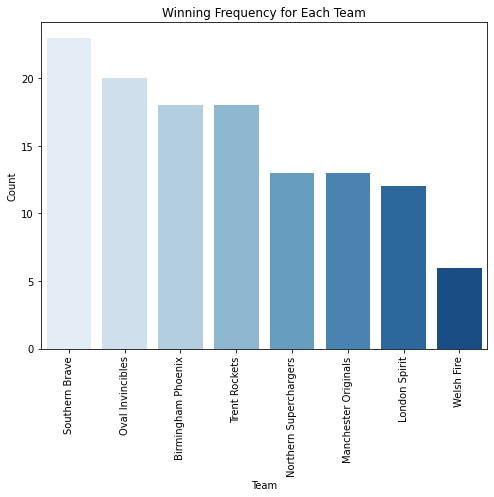

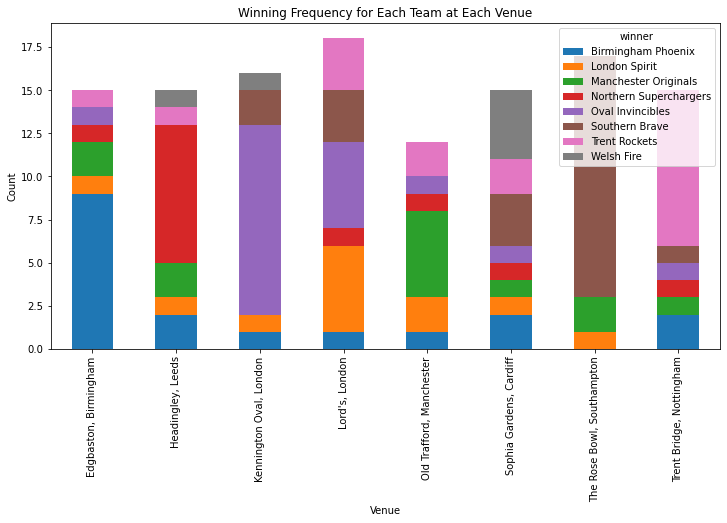

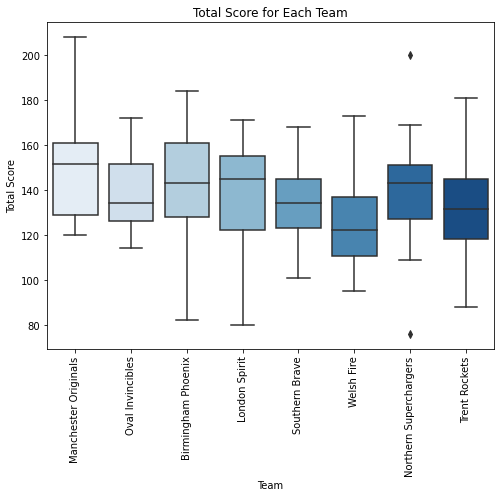

In [150]:
# 设置调色板
cmap = sns.color_palette("Blues", n_colors=len(df_bat['team'].unique()))

plt.figure(figsize=(8,6))
sns.countplot(x='winner', data=df_bat, order = df_bat['winner'].value_counts().index, palette=cmap)
plt.title('Winning Frequency for Each Team')
plt.xlabel('Team')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

venue_team = pd.crosstab(df_bat['venue'], df_bat['winner'])
venue_team.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Winning Frequency for Each Team at Each Venue')
plt.xlabel('Venue')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='team', y='total_score', data=df_bat, palette=cmap)
plt.title('Total Score for Each Team')
plt.xlabel('Team')
plt.ylabel('Total Score')
plt.xticks(rotation=90)
plt.show()

In [ ]:
opponents = df_bat['opponent'].unique()  
opponent_win_rates = {}  
for opponent in opponents:
    opponent_wins = df_bat['opponent'][df_bat['winner'] == opponent].count()
    opponent_matches = df_bat[(df_bat['opponent'] == opponent) | (df_bat['opponent'] == team)]['team'].count()
    win_rate = team_wins / team_matches
    win_rates[team] = win_rate

win_rates_df = pd.DataFrame(list(win_rates.items()), columns=['Team', 'Win Rate'])
win_rates_df

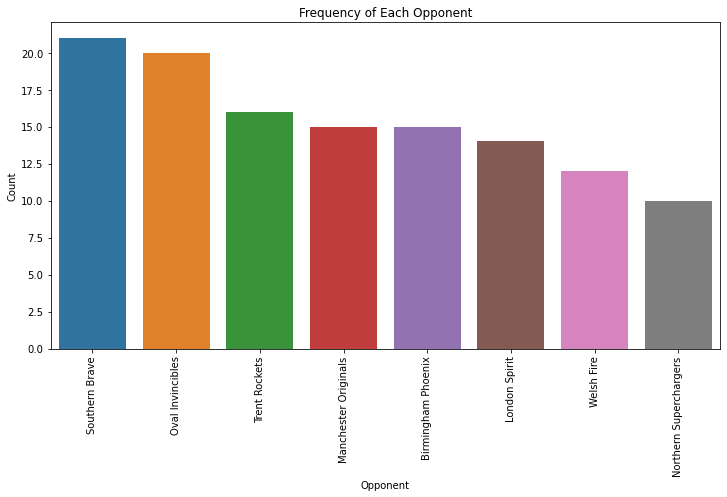

Win Rate for Toss Winner:
0.45528455284552843
Win Rate for Each City:
0.0


In [125]:
plt.figure(figsize=(12,6))
sns.countplot(x='opponent', data=df_bat, order = df_bat['opponent'].value_counts().index)
plt.title('Frequency of Each Opponent')
plt.xlabel('Opponent')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# # 然后，我们可以看看每个对手的胜率
# opponent_wins = df_bat['opponent'][df_bat['winner'] == df_bat['opponent']].count()
# opponent_matches = df_bat['opponent'].count()
# opponent_win_rate = opponent_wins / opponent_matches
# print('Win Rate for Each Opponent:')
# print(opponent_win_rate)

# 对于 'toss_winner' 变量，我们可以看看赢得开球的队伍是否更可能赢得比赛
toss_wins = df_bat['winner'][df_bat['winner'] == df_bat['toss_winner']].count()
toss_total = df_bat['toss_winner'].count()
toss_win_rate = toss_wins / toss_total
print('Win Rate for Toss Winner:')
print(toss_win_rate)

# 最后，我们可以看看每个城市的胜率
city_wins = df_bat['city'][df_bat['winner'] == df_bat['city']].count()
city_matches = df_bat['city'].count()
city_win_rate = city_wins / city_matches
print('Win Rate for Each City:')
print(city_win_rate)

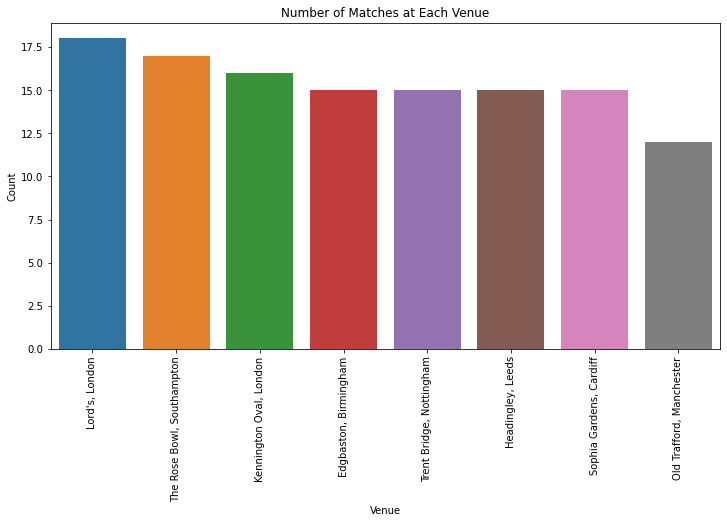

Home Team Win Rate for Each Venue:
0.44715447154471544


In [126]:
# 首先，我们可以查看每个场地的比赛次数
plt.figure(figsize=(12,6))
sns.countplot(x='venue', data=df_bat, order = df_bat['venue'].value_counts().index)
plt.title('Number of Matches at Each Venue')
plt.xlabel('Venue')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# 接下来，我们可以看看在各个场地主队的胜率
venue_wins = df_bat['venue'][df_bat['winner'] == df_bat['team']].count()
venue_matches = df_bat['venue'].count()
venue_win_rate = venue_wins / venue_matches
print('Home Team Win Rate for Each Venue:')
print(venue_win_rate)

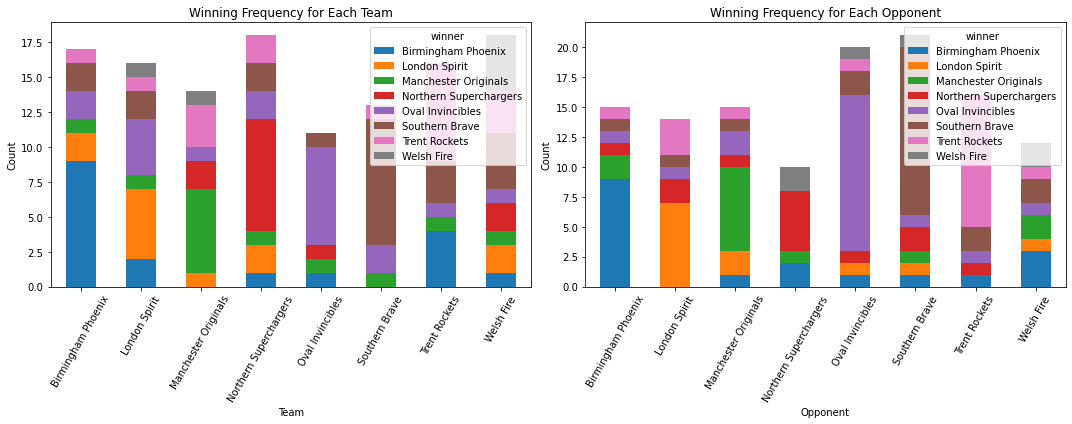

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

cross_team = pd.crosstab(df_bat['team'], df_bat['winner'])
cross_team.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_title('Winning Frequency for Each Team')
ax[0].set_xlabel('Team')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=60)

cross_opponent = pd.crosstab(df_bat['opponent'], df_bat['winner'])
cross_opponent.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Winning Frequency for Each Opponent')
ax[1].set_xlabel('Opponent')
ax[1].set_ylabel('Count')
ax[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

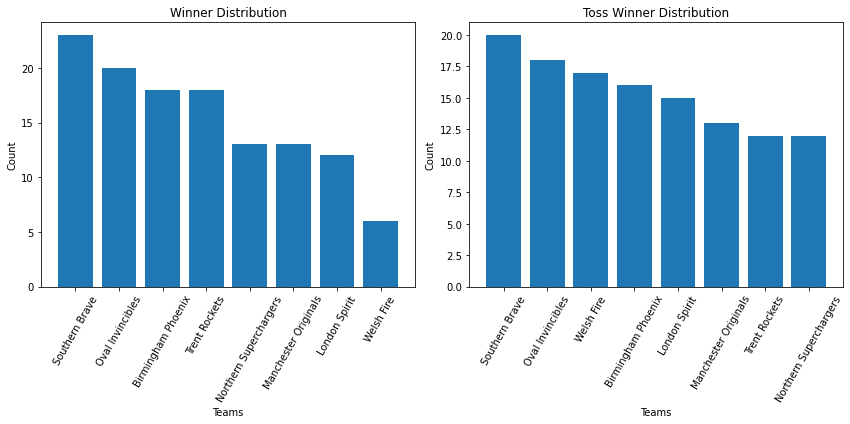

In [57]:
#toss_winner and winner
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

winner_counts = df_bat['winner'].value_counts()
ax[0].bar(winner_counts.index, winner_counts.values)
ax[0].set_title('Winner Distribution')
ax[0].set_xlabel('Teams')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=60)

toss_winner_counts = df_bat['toss_winner'].value_counts()
ax[1].bar(toss_winner_counts.index, toss_winner_counts.values)
ax[1].set_title('Toss Winner Distribution')
ax[1].set_xlabel('Teams')
ax[1].set_ylabel('Count')
ax[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

In [58]:
from scipy.stats import chi2_contingency

cross_tab = pd.crosstab(df_bat['toss_winner'], df_bat['winner'])
chi2, p, dof, expected = chi2_contingency(cross_tab)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")

Chi-square statistic: 144.2896446817586
p-value: 2.5263710852045262e-11


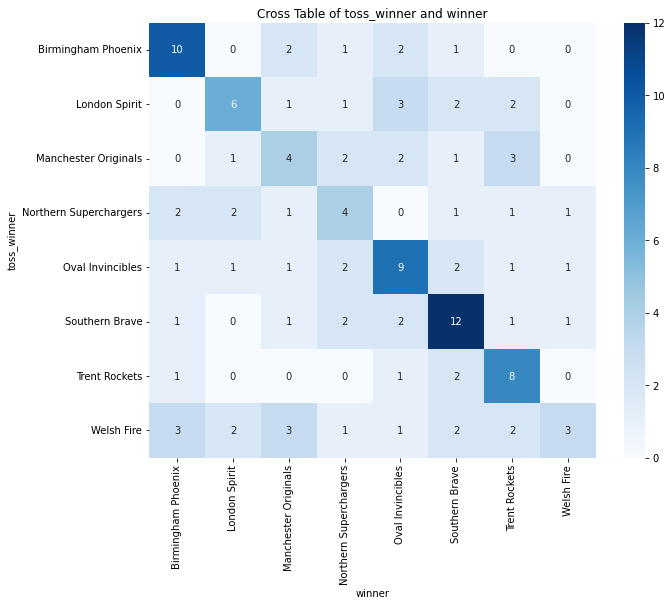

In [68]:
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="Blues")
plt.title('Cross Table of toss_winner and winner')
plt.show()

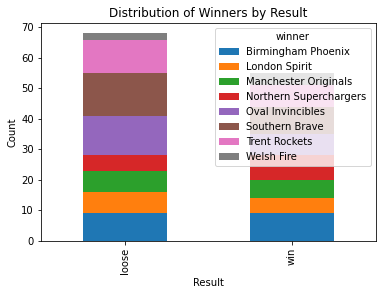

In [83]:
df_bat.groupby('Result')['winner'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Winners by Result')
plt.xlabel('Result')
plt.ylabel('Count')
plt.show()

In [44]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.express as px

df_bat = pd.read_csv('/Users/quinne/Desktop/final_dataframe.csv')  # Load your data

# Create a Dash application
app = dash.Dash(__name__)

# Define the layout
app.layout = html.Div([
    html.H1("Cricket Match Dashboard", style={'textAlign': 'center'}),

    dcc.Dropdown(id='team-dropdown',
                 options=[{'label': i, 'value': i} for i in df_bat['team'].unique()],
                 value='team1',
                 style={'width': '40%'}
                 ),

    dcc.Graph(id='team-graph'),

    dcc.Dropdown(id='venue-dropdown',
                 options=[{'label': i, 'value': i} for i in df_bat['venue'].unique()],
                 value='venue1',
                 style={'width': '40%'}
                 ),

    dcc.Graph(id='venue-graph'),

    # Add more components as needed
])

# Define callbacks to update Graph
@app.callback(
    dash.dependencies.Output('team-graph', 'figure'),
    [dash.dependencies.Input('team-dropdown', 'value')]
)
def update_graph(selected_team):
    filtered_df = df_bat[df_bat['team'] == selected_team]

    fig = px.histogram(filtered_df, x='total_score', nbins=20)

    return fig

@app.callback(
    dash.dependencies.Output('venue-graph', 'figure'),
    [dash.dependencies.Input('venue-dropdown', 'value')]
)
def update_graph(selected_venue):
    filtered_df = df_bat[df_bat['venue'] == selected_venue]

    fig = px.histogram(filtered_df, x='total_score', nbins=20)

    return fig

# Run the application
if __name__ == '__main__':
    app.run_server(debug=True)


/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_43544/794693995.py:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_43544/794693995.py:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [253]:
contingency_table = pd.crosstab(df_bat['last_match_result'], df_bat['home_advantage'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("chi2 statistic", chi2)
print("p value", p)

chi2 statistic 6.826950778784486
p value 0.03292656864891756


In [256]:
df_bat['Result'] = df_bat['Result'].map({"win": 1, "lose": 0})

In [258]:
df_bat['last_match_result'] = df_bat['last_match_result'].map({'yes': 1, 'no': 0, '0':0})
df_bat['home_advantage'] = df_bat['home_advantage'].map({'yes': 1, 'no': 0})

In [260]:
df_bat['last_match_result'].unique 

<bound method Series.unique of 0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
118   NaN
119   NaN
120   NaN
121   NaN
122   NaN
Name: last_match_result, Length: 123, dtype: float64>

In [45]:
# 导入所需的库
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go


app = dash.Dash(__name__)

app.layout = html.Div(children=[
    html.H1(children='Hello Dash'),

    html.Div(children='''
        Dash: A web application framework for Python.
    '''),

    # ...（省略了其他代码）

      dcc.Graph(
          id='boxplot',
         figure={
           'data': [
              go.Box(
                 y=df_bat['total_score'],  # 替换为你的变量名
                 name='total_score'  # 图表的标签
            ),
        ],
        'layout': {
            'title': 'Boxplot of total score'
        }
    }
)


        
    
])

if __name__ == '__main__':
    app.run_server(debug=True)

In [85]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px

# Generate the figures
fig_winner = px.histogram(df_bat, x="winner")
fig_toss_winner = px.histogram(df_bat, x="toss_winner")

app = dash.Dash(__name__)

app.layout = html.Div(children=[
    html.H1(children='Cricket Match Dashboard'),

    html.Div(children='''
        Dash: A web application framework for Python.
    '''),

    dcc.Graph(
        id='graph_winner',
        figure=fig_winner
    ),

    dcc.Graph(
        id='graph_toss_winner',
        figure=fig_toss_winner
    )
])

if __name__ == '__main__':
    app.run_server(debug=True)
